# Lesson 6.动态计算图与梯度下降入门

&emsp;&emsp;在《Lesson 5.基本优化思想与最小二乘法》的结尾，我们提到PyTorch中的AutoGrad（自动微分）模块，并简单尝试使用该模块中的`autograd.grad`进行函数的微分运算，我们发现，`autograd.grad`函数可以灵活进行函数某一点的导数或偏导数的运算，但微分计算其实也只是AutoGrad模块中的一小部分功能。本节课，我们将继续讲解AutoGrad模块中的其他常用功能，并在此基础上介绍另一个常用优化算法：梯度下降算法。

In [1]:
import numpy as np
import torch

## 一、AutoGrad的回溯机制与动态计算图

### 1.可微分性相关属性

&emsp;&emsp;在上一节中我们提到，新版PyTorch中的张量已经不仅仅是一个纯计算的载体，张量本身也可支持微分运算。这种可微分性其实不仅体现在我们可以使用grad函数对其进行求导，更重要的是这种可微分性会体现在可微分张量参与的所有运算中。

- requires_grad属性：可微分性

In [2]:
# 构建可微分张量
x = torch.tensor(1.,requires_grad = True)
x

tensor(1., requires_grad=True)

In [3]:
# 构建函数关系
y = x ** 2

- grad_fn属性：存储Tensor微分函数

In [4]:
y

tensor(1., grad_fn=<PowBackward0>)

我们发现，此时张量y具有了一个`grad_fn`属性，并且取值为`<PowBackward0>`，我们可以查看该属性

In [5]:
y.grad_fn

`grad_fn`其实是存储了Tensor的微分函数，或者说`grad_fn`存储了可微分张量在进行计算的过程中函数关系，此处x到y其实就是进行了幂运算。

In [6]:
# 但x作为初始张量，并没有grad_fn属性
x.grad_fn

这里值得主要的是，y不仅和x存在幂运算关系（y = x\**2），更重要的是，y本身还是一个有x张量计算得出的一个张量

In [7]:
y

tensor(1., grad_fn=<PowBackward0>)

而对于一个可微分张量生成的张量，也是可微分的

In [8]:
y.requires_grad

True

也就是相比于x，y不仅同样拥有张量的取值，并且同样可微，还额外存储了x到y的函数计算信息。我们再尝试围绕y创建新的函数关系，z = y + 1

In [9]:
z = y + 1

In [10]:
z

tensor(2., grad_fn=<AddBackward0>)

In [11]:
z.requires_grad

True

In [12]:
z.grad_fn

不难发现，z也同时存储了张量计算数值、z是可微的，并且z还存储了和y的计算关系（add）。据此我们可以知道，在PyTorch的张量计算过程中，如果我们设置初始张量是可微的，则在计算过程中，每一个由原张量计算得出的新张量都是可微的，并且还会保存此前一步的函数关系，这也就是所谓的回溯机制。而根据这个回溯机制，我们就能非常清楚掌握张量的每一步计算，并据此绘制张量计算图。

### 2.张量计算图

&emsp;&emsp;借助回溯机制，我们就能将张量的复杂计算过程抽象为一张图（Graph），例如此前我们定义的x、y、z三个张量，三者的计算关系就可以由下图进行表示。

<img src="https://i.loli.net/2021/01/23/cgrnBZqPS3vWM6U.jpg" alt="10" style="zoom:50%;" />

- 计算图的定义

&emsp;&emsp;上图就是用于记录可微分张量计算关系的张量计算图，图由节点和有向边构成，其中节点表示张量，边表示函数计算关系，方向则表示实际运算方向，张量计算图本质是有向无环图。

- 节点类型      

&emsp;&emsp;在张量计算图中，虽然每个节点都表示可微分张量，但节点和节点之间却略有不同。就像在前例中，y和z保存了函数计算关系，但x没有，而在实际计算关系中，我们不难发现z是所有计算的终点，因此，虽然x、y、z都是节点，但每个节点却并不一样。此处我们可以将节点分为三类，分别是：     
a)：叶节点，也就是初始输入的可微分张量，前例中x就是叶节点；      
b)：输出节点，也就是最后计算得出的张量，前例中z就是输出节点；      
c)：中间节点，在一张计算图中，除了叶节点和输出节点，其他都是中间节点，前例中y就是中间节点。      
当然，在一张计算图中，可以有多个叶节点和中间节点，但大多数情况下，只有一个输出节点，若存在多个输出结果，我们也往往会将其保存在一个张量中。

### 3.计算图的动态性

&emsp;&emsp;值得一提的是，PyTorch的计算图是动态计算图，会根据可微分张量的计算过程自动生成，并且伴随着新张量或运算的加入不断更新，这使得PyTorch的计算图更加灵活高效，并且更加易于构建，相比于先构件图后执行计算的部分框架（如老版本的TensorFlow），动态图也更加适用于面向对象编程。

## 二、反向传播与梯度计算

### 1.反向传播的基本过程

&emsp;&emsp;在《Lesson 5.》中，我们曾使用autograd.grad进行函数某一点的导数值得计算，其实，除了使用函数以外，我们还有另一种方法，也能进行导数运算：反向传播。当然，此时导数运算结果我们也可以有另一种解读：计算梯度结果。

> 注：此处我们暂时不区分微分运算结果、导数值、梯度值三者区别，目前位置三个概念相同，后续讲解梯度下降时再进行区分。

首先，对于某一个可微分张量的导数值（梯度值），存储在grad属性中。

In [13]:
x.grad

在最初，x.grad属性是空值，不会返回任何结果，我们虽然已经构建了x、y、z三者之间的函数关系，x也有具体取值，但要计算x点导数，还需要进行具体的求导运算，也就是执行所谓的反向传播。所谓反向传播，我们可以简单理解为，在此前记录的函数关系基础上，反向传播函数关系，进而求得叶节点的导数值。在必要时求导，这也是节省计算资源和存储空间的必要规定。

In [14]:
z

tensor(2., grad_fn=<AddBackward0>)

In [15]:
z.grad_fn

In [16]:
# 执行反向传播
z.backward()

反向传播结束后，即可查看叶节点的导数值

In [17]:
x

tensor(1., requires_grad=True)

In [18]:
# 在z=y+1=x**2+1函数关系基础上，x取值为1时的导数值
x.grad

tensor(2.)

注意，在默认情况下，在一张计算图上执行反向传播，只能计算一次，再次调用backward方法将报错

In [19]:
z.backward()

RuntimeError: ignored

当然，在y上也能执行反向传播

In [26]:
x = torch.tensor(1.,requires_grad = True)
y = x ** 3
z = y + 1

In [27]:
y.backward()

In [28]:
x.grad

tensor(3.)

第二次执行时也会报错

In [23]:
y.backward()

RuntimeError: ignored

In [24]:
z.backward()

RuntimeError: ignored

无论何时，我们只能计算叶节点的导数值

In [25]:
y.grad

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


至此，我们就了解了反向传播的基本概念和使用方法：      
- 反向传播的本质：函数关系的反向传播（不是反函数）； 
- 反向传播的执行条件：拥有函数关系的可微分张量（计算图中除了叶节点的其他节点）；
- 反向传播的函数作用：计算叶节点的导数/微分/梯度运算结果；

### 2.反向传播运算注意事项

- 中间节点反向传播和输出节点反向传播区别

&emsp;&emsp;尽管中间节点也可进行反向传播，但很多时候由于存在复合函数关系，中间节点反向传播的计算结果和输出节点反向传播输出结果并不相同。

In [29]:
x = torch.tensor(1.,requires_grad = True)
y = x ** 2
z = y ** 2

In [30]:
z.backward()

In [31]:
x.grad

tensor(4.)

In [32]:
x = torch.tensor(1.,requires_grad = True)
y = x ** 2
z = y ** 2

In [33]:
y.backward()
x.grad

tensor(2.)

- 中间节点的梯度保存

&emsp;&emsp;默认情况下，在反向传播过程中，中间节点并不会保存梯度

In [34]:
x = torch.tensor(1.,requires_grad = True)
y = x ** 2
z = y ** 2

In [35]:
z.backward()
y.grad

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


In [36]:
x.grad

tensor(4.)

若想保存中间节点的梯度，我们可以使用retain_grad()方法

In [37]:
x = torch.tensor(1.,requires_grad = True)
y = x ** 2
y.retain_grad()
z = y ** 2

In [39]:
z.backward()

In [40]:
y

tensor(1., grad_fn=<PowBackward0>)

In [41]:
y.grad

tensor(2.)

In [42]:
x.grad

tensor(4.)

### 3.阻止计算图追踪

&emsp;&emsp;在默认情况下，只要初始张量是可微分张量，系统就会自动追踪其相关运算，并保存在计算图关系中，我们也可通过grad_fn来查看记录的函数关系，但在特殊的情况下，我们并不希望可微张量从创建到运算结果输出都被记录，此时就可以使用一些方法来阻止部分运算被记录。

- with torch.no_grad()：阻止计算图记录

&emsp;&emsp;例如，我们希望x、y的函数关系被记录，而y的后续其他运算不被记录，可以使用with torch.no_grad()来组织部分y的运算不被记录。

In [43]:
x = torch.tensor(1.,requires_grad = True)
y = x ** 2

In [44]:
with torch.no_grad():
    z = y ** 2

with相当于是一个上下文管理器，with torch.no_grad()内部代码都“屏蔽”了计算图的追踪记录

In [45]:
z

tensor(1.)

In [46]:
z.requires_grad

False

In [ ]:
y

tensor(1., grad_fn=<PowBackward0>)

- .detach()方法：创建一个不可导的相同张量

在某些情况下，我们也可以创建一个不可导的相同张量参与后续运算，从而阻断计算图的追踪

In [47]:
x = torch.tensor(1.,requires_grad = True)
y = x ** 2
y1 = y.detach()
z = y1 ** 2

In [48]:
y

tensor(1., grad_fn=<PowBackward0>)

In [49]:
y1

tensor(1.)

In [50]:
z

tensor(1.)

### 4.识别叶节点

&emsp;&emsp;由于叶节点较为特殊，如果需要识别在一个计算图中某张量是否是叶节点，可以使用is_leaf属性查看对应张量是否是叶节点。

In [51]:
x.is_leaf

True

In [52]:
y.is_leaf

False

但is_leaf方法也有容易混淆的地方，对于任何一个新创建的张量，无论是否可导、是否加入计算图，都是可以是叶节点，这些节点距离真正的叶节点，只差一个requires_grad属性调整。

In [53]:
torch.tensor([1]).is_leaf

True

In [54]:
# 经过detach的张量，也可以是叶节点
y1

tensor(1.)

In [55]:
y1.is_leaf

True

### 三、梯度下降基本思想

&emsp;&emsp;有了AutoGrad模块中各函数方法的支持，接下来，我们就能尝试手动构建另一个优化算法：梯度下降算法。

### 1.最小二乘法的局限与优化

&emsp;&emsp;在《Lesson 5.》中，我们尝试使用最小二乘法求解简单线性回归的目标函数，并顺利的求得了全域最优解。但正如上节所说，在所有的优化算法中最小二乘法虽然高效并且结果精确，但也有不完美的地方，核心就在于最小二乘法的使用条件较为苛刻，要求特征张量的交叉乘积结果必须是满秩矩阵，才能进行求解。而在实际情况中，很多数据的特征张量并不能满足条件，此时就无法使用最小二乘法进行求解。

最小二乘法结果：

$$\hat w ^T = (X^TX)^{-1}X^Ty$$

&emsp;&emsp;当最小二乘法失效的情况时，其实往往也就代表原目标函数没有最优解或最优解不唯一。针对这样的情况，有很多中解决方案，例如，我们可以在原矩阵方程中加入一个扰动项$\lambda I$，修改后表达式如下：

$$\hat w ^{T*} = (X^TX + \lambda I)^{-1}X^Ty$$

其中，$\lambda$是扰动项系数，$I$是单元矩阵。由矩阵性质可知，加入单位矩阵后，$(X^TX + \lambda I)$部分一定可逆，而后即可直接求解$\hat w^{T*}$，这也就是岭回归的一般做法。

&emsp;&emsp;当然，上式修改后求得的结果就不再是全域最小值，而是一个接近最小值的点。鉴于许多目标函数本身也并不存在最小值或者唯一最小值，在优化的过程中略有偏差也是可以接受的。当然，伴随着深度学习的逐渐深入，我们会发现，最小值并不唯一存在才是目标函数的常态。基于此情况，很多根据等式形变得到的精确的求解析解的优化方法（如最小二乘）就无法适用，此时我们需要寻找一种更加通用的，能够高效、快速逼近目标函数优化目标的最优化方法。在机器学习领域，最通用的求解目标函数的最优化方法就是著名的梯度下降算法。

&emsp;&emsp;值得一提的是，我们通常指的梯度下降算法，并不是某一个算法，而是某一类依照梯度下降基本理论基础展开的算法簇，包括梯度下降算法、随机梯度下降算法、小批量梯度下降算法等等。接下来，我们就从最简单的梯度下降入手，讲解梯度下降的核心思想和一般使用方法。

### 2.梯度下降核心思想

&emsp;&emsp;梯度下降的基本思想其实并不复杂，其核心就是希望能够通过数学意义上的迭代运算，从一个随机点出发，一步步逼近最优解。

例如，在此前求解简单线性回归方程的过程中，我们曾查看SSE的三维函数图像如下：

In [56]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [57]:
x = np.arange(-1,3,0.05)
y = np.arange(-1,3,0.05)
a, b = np.meshgrid(x, y)
SSE = (2 - a - b) ** 2 + (4 - 3 * a - b) ** 2

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


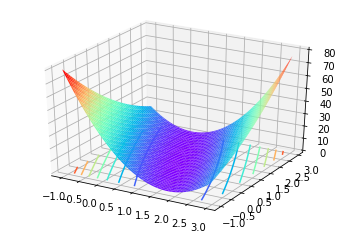

In [58]:
fig = plt.figure()  
ax = plt.axes(projection='3d')

ax.plot_surface(a, b, SSE, cmap='rainbow')
ax.contour(a, b, SSE, zdir='z', offset=0, cmap="rainbow")  #生成z方向投影，投到x-y平面
plt.show()

而梯度下降，作为最优化算法，核心目标也是找到或者逼近最小值点，而其基本过程则：
- 在目标函数上随机找到一个初始点；
- 通过迭代运算，一步步逼近最小值点；

<img src="https://i.loli.net/2021/01/23/caNAtMFI5dqhfH6.jpg" alt="11" style="zoom:50%;" />

> 数学意义上的迭代运算，指的是上一次计算的结果作为下一次运算的初始条件带入运算

### 3.梯度下降的方向与步长

&emsp;&emsp;当然，梯度下降的基本思想好理解，但实现起来却并不容易（这也是大多数机器学习算法的常态）。在实际沿着目标函数下降的过程中，我们核心需要解决两个问题，其一是往哪个方向走，其二是每一步走多远。以上述简单线性回归的目标函数为例，在三维空间中，目标函数上的每个点理论上都有无数个移动的方向，每次移动多远的物理距离也没有明显的约束，而这些就是梯度下降算法核心需要解决的问题，也就是所谓的方向和步长。

首先，是关于方向的讨论。

> 关于方向的讨论，其实梯度下降是采用了一种局部最优推导全域最优的思路，我们首先是希望能够找到让目标函数变化最快的方向作为移动的方向，而这个方向，就是梯度。

#### 3.1 导数与梯度

&emsp;&emsp;我们都知道，函数上某一点的导数值的几何含义就是函数在该点上切线的斜率。例如y=x**2中，x在1点的导数就是函数在1点的切线的斜率。

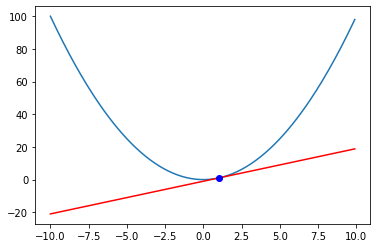

In [59]:
x = np.arange(-10,10,0.1)
y = x ** 2                          # y = 2x
z = 2 * x - 1                       # 在（1，1）点的切线方程
plt.plot(x, y, '-')
plt.plot(x, z, 'r-')
plt.plot(1, 1, 'bo')
plt.show()

而更进一步来讲，对于上述函数，x取值为1的时候，导数和切线的斜率为2，代表含义是给1这个点一个无穷小的增量，1只能沿着切向方向移动（但仍然在曲线上）。当然，该点导数值的另外一个解释就是该点的梯度，梯度的值（grad）和导数相同，而梯度的概念可以视为导数概念的延申，只不过梯度更侧重方向的概念，也就是从梯度的角度解读导数值，就代表着当前这个点的可以使得y值增加最快的移动方向。

梯度：梯度本身是一个代表方向的矢量，代表某一函数在该点处沿着梯度方向变化时，变化率最大。当然，梯度的正方向代表函数值增长最快的方向，梯度的负方向表示函数减少最快的方向。

In [60]:
x = torch.tensor(1., requires_grad = True)
y = x ** 2

In [61]:
y.backward()

In [62]:
x.grad

tensor(2.)

不过此时由于自变量存在一维空间，只能沿着x轴变化（左右移动，只有两个方向），梯度给出的方向只能解读为朝着2，也就是正方向变化时，y的增加最快（确实如此，同时也显而易见）。

#### 3.2 梯度与方向

&emsp;&emsp;为了更好的解读梯度与方向之间的关系，我们以《Lesson 5.》中简单线性回归损失函数为例来进行查看。我们有目标函数及其图像如下：

<center>$SSE_{(a, b)} =  (2 - a - b)^2 + (4 - 3a - b)^2$</center>    

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


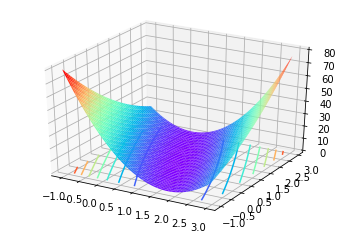

In [63]:
fig = plt.figure()  
ax = plt.axes(projection='3d')

ax.plot_surface(a, b, SSE, cmap='rainbow')
ax.contour(a, b, SSE, zdir='z', offset=0, cmap="rainbow")  #生成z方向投影，投到x-y平面
plt.show()

此时a、b是在实数域上取值。假设二者初始值为0，也就是初始随机点为原点。对于（0，0）点，有梯度计算如下

In [64]:
a = torch.tensor(0., requires_grad = True)
a

tensor(0., requires_grad=True)

In [65]:
b = torch.tensor(0., requires_grad = True)
b

tensor(0., requires_grad=True)

In [66]:
s0 = torch.pow((2 - a - b), 2) + torch.pow((4 - 3 * a - b), 2)

In [67]:
s0

tensor(20., grad_fn=<AddBackward0>)

In [68]:
s0.backward()

In [69]:
a.grad, b.grad

(tensor(-28.), tensor(-12.))

也就是原点和（-28，-12）这个点之间连成直线的方向，就是能够使得sse变化最快的方向，并且朝向（-28，-12）方向就是使得sse增加最快的方向，反方向则是令sse减少最快的方向。

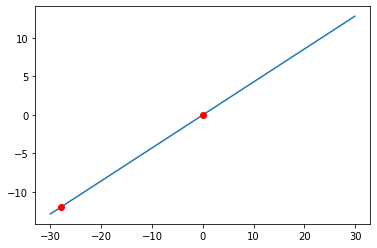

In [77]:
# 通过绘制直线，确定原点的移动方向
x = np.arange(-30,30,0.1)
y = (12/28) * x                     
plt.plot(x, y, '-')
plt.plot(0, 0, 'ro')
plt.plot(-28, -12, 'ro')

**Point:**这里有关于方向的两点讨论      
- 方向没有大小，虽然这是个显而易见的观点，但我们当我们说朝着（-28，-12）方向移动，只是说沿着直线移动，并非一步移动到（-28，-12）上；      
- 方向跟随梯度，随时在发生变化。值得注意的是，一旦点发生移动，梯度就会随之发生变化，也就是说，哪怕是沿着让sse变化最快的方向移动，一旦“沿着方向”移动了一小步，这个方向就不再是最优方向了。

当然，逆梯度值的方向变化是使得sse变小的最快方向，我们尝试移动“一小步”。一步移动到(28,12)是没有意义的，梯度各分量数值的绝对值本身也没有距离这个层面的数学含义。由于a和b的取值要按照（28，12）等比例变化，因此我们不妨采用如下方法进行移动：

$$ \left [\begin{array}{cccc}
0 \\
0 \\
\end{array}\right] + 0.01 * 
\left [\begin{array}{cccc}
28 \\
12 \\
\end{array}\right] =
\left [\begin{array}{cccc}
0.28 \\
0.12 \\
\end{array}\right]$$

In [78]:
s0

tensor(20., grad_fn=<AddBackward0>)

In [79]:
a = torch.tensor(0.28, requires_grad = True)
a

tensor(0.2800, requires_grad=True)

In [73]:
b = torch.tensor(0.12, requires_grad = True)
b

tensor(0.1200, requires_grad=True)

In [74]:
s1 = (2 - a - b) ** 2 + (4 - 3 * a - b) ** 2
s1

tensor(11.8016, grad_fn=<AddBackward0>)

确实有所下降，继续求解新的点的梯度

In [75]:
s1.backward()

In [76]:
a.grad, b.grad

(tensor(-21.4400), tensor(-9.2800))

不难看出，方向已经发生变化。其实无论移动“多小”一步，只要移动，方向就需要重新计算。如果每个点的梯度提供了移动方向的最优解，那移动多长，其实并没有统一的规定。这里，我们将上述0.01称作学习率，而学习率乘以梯度，则是原点移动的“长度”。

当然，在移动到(0.28,0.12)之后，还没有取到全域最优解，因此还需要继续移动，当然我们还可以继续按照0.01这个学习率继续移动，此时，新的梯度为（-21.44,-9.28)，则有

$$ \left [\begin{array}{cccc}
0.28 \\
0.12 \\
\end{array}\right] + 0.01 * 
\left [\begin{array}{cccc}
21.44 \\
9.28 \\
\end{array}\right] =
\left [\begin{array}{cccc}
0.4944 \\
0.2128 \\
\end{array}\right]$$

接下来，我们可以继续计算新的(0.94,0.148)这个点的梯度，然后继续按照学习率0.01继续移动，在移动若干次之后，就将得到非常接近于（1，1）的结果。

## 四、梯度下降的数学表示

### 1.梯度下降的代数表示

&emsp;&emsp;根据上述描述过程，我们可以通过代数运算方式总结梯度下降运算的一般过程

令多元线性回归方程为

<center> $ f(x) = w_1x_1+w_2x_2+...+w_dx_d+b $ </center>

令

$$\hat w = (w_1,w_2,...,w_d,b)$$

$$\hat x = (x_1,x_2,...,x_d,1)$$

出于加快迭代收敛速度的目标，我们在定义梯度下降的损失函数L时，在原SSE基础上进行比例修正，新的损失函数$L(w_1,w_2,...,w_d,b) = \frac{1}{2m}SSE$，其中，m为样本个数。

损失函数有：

 $$
   L(w_1,w_2,...,w_d,b) = \frac{1}{2m}\sum_{j=0}^{m}(f(x_1^{(j)}, x_2^{(j)}, ...1) - y_j)^2
   $$

并且，根据此前描述过程，在开始梯度下降求解参数之前，我们首先需要设置一组参数的初始取值$(w_1, w_2..., w_d, b)$，以及学习率$\alpha$，然后即可执行迭代运算，其中每一轮迭代过程需要执行以下三步

Step 1.计算梯度表达式

对于任意一个参数$w_i$，其梯度计算表达式如下：

$$\frac{\partial}{\partial w_i}L(w_1, w_2..., w_d, b)$$

Step 2.用学习率乘以损失函数梯度，得到迭代移动距离

$$\alpha \frac{\partial}{\partial w_i}L(w_1, w_2..., w_d, b)$$

Step 3.用原参数减Step 2中计算得到的距离，更新所有的参数w

$$w_i = w_i - \alpha \frac{\partial}{\partial w_i}L(w_1, w_2..., w_d, b)$$

更新完所有参数，即完成了一轮的迭代，接下来就能以新的一组$w_i$参与下一轮迭代。

> 上一轮计算结果作为下一轮计算的初始值，就是所谓的迭代。

而何时停止迭代，一般来说有两种情况，其一是设置迭代次数，到达迭代次数即停止迭代；其二则是设置收敛区间，即当某两次迭代过程中，每个$w_i$更新的数值都小于某个预设的值，则停止迭代。

### 2.再次理解步长

根据梯度下降的线性代数表示方法，我们可以通过某个实例来强化理解步长这一概念。

有数据集表示如下：

|x|y|
| :------: | :------: |
| 1 | 2 |
| 2 | 4 |
| 3 | 6 |

假设，我们使用$y = wx$进行拟合，则SSE为：

$$ \begin{align} SSE
& = (2-1*w)^2 + (4-2*w)^2 + (6-3*w)^2 \\
& = w^2-4w+4+4w^2-16w+16+9w^2-36w+36 \\
& = 14w^2-56w+56 \\
& = 14(w^2-4w+4)  \end{align} $$

此时，SSE就是一个关于w的一元函数。当使用最小二乘法进行求解时，SSE就是损失函数，并且SSE对于w求导为0的点就是最小值点，因此有：

<center>$ \begin{align} \frac{\partial{SSE_{(a)}}}{\partial{(a)}}  
& = 14(2w-4)\\
& = 28(w-2) \\
& = 0  \end{align} $</center>

$$w=2$$

但我们使用梯度下降求解时：

<center>$ \begin{align} 
grad^*
& = \frac{\partial{SSE_{(a)}}}{\partial{(a)}} \\
& = 14(2w-4) \\
& = 28(w-2) \\
\end{align} $</center>

由于梯度表示方向，在某些情况下我们可以对其绝对数值进行一定程度上的“缩放”，此时我们规定有效梯度是原梯度的1/28，则有

$$grad = w-2 $$

设步长$\alpha=$0.5，初始值点取为$w_0=0$，则迭代过程如下：

第一轮迭代：

$$grad(w_0)=grad(0)=-2,w_0=0,w_1=w_0-\alpha*grad(w_0)=0-\frac{1}{2}(-2)=1$$

第二轮迭代：

$$grad(w_1)=grad(1)=-1,w_1=1,w_2=w_1-\alpha*grad(w_1)=1-\frac{1}{2}(-1)=\frac{3}{2}$$

第三轮迭代：

$$grad(w_2)=grad(\frac{3}{2})=-\frac{1}{2},w_2=\frac{3}{2},w_3=w_2-\alpha*grad(w_2)=\frac{3}{2}-\frac{1}{2}(-\frac{1}{2})=\frac{7}{4}$$

第四轮迭代：

$$grad(w_3)=grad(\frac{7}{4})=-\frac{1}{4},w_3=\frac{7}{4},w_4=w_3-\alpha*grad(w_3)=\frac{7}{4}-\frac{1}{2}(-\frac{1}{4})=\frac{15}{8}$$

依次类推：

$$
w_5 = \frac{15}{8}+\frac{1}{16} = \frac{31}{16};
w_6 = \frac{31}{16}+\frac{1}{32} = \frac{63}{32};
w_7 = \frac{63}{32}+\frac{1}{64} = \frac{127}{64};
...
$$

$$w_n=\frac{2^n-1}{2^{n-1}} = 2-\frac{1}{2^{n-1}}$$

$$\lim_{n→\infty} (w_n) = \lim_{n→\infty} (2-\frac{1}{2^{n-1}}) = 2$$

我们不难发现，如果损失函数是凸函数，并且全域最小值存在，则步长可以表示当前点和最小值点之间距离的比例关系。但总的来说，对于步长的设置，我们有如下初步结论：

- 步长太短：会极大的影响迭代收敛的时间，整体计算效率会非常低；

<img src="https://i.loli.net/2021/01/23/jDFKx6sMePUYpIn.jpg" alt="14" style="zoom:50%;" />

- 步长太长：容易跳过最优解，导致结果震荡。      

<img src="https://i.loli.net/2021/01/23/2a1ZEAz7BILrReO.jpg" alt="13" style="zoom:50%;" />

关于步长的设置，其实更多的会和实际使用情况相关，和实际损失函数特性相关，因此我们会在后续使用梯度下降求解目标函数时根据实际情况，讲解步长的实际调整策略。

### 3.梯度下降的矩阵表示

&emsp;&emsp;和最小二乘法一样，代数表示形式易于理解但不易与代码操作，在实际编程实现梯度下降的过程中，我们还是更倾向于使用矩阵来表示梯度下降计算过程。

<center> $ f(x) = w_1x_1+w_2x_2+...+w_dx_d+b $ </center>

令

$$\hat w = (w_1,w_2,...,w_d,b)$$

$$\hat x = (x_1,x_2,...,x_d,1)$$

- $\hat w$：方程系数所组成的向量，并且我们将自变量系数和截距放到了一个向量中，此处$\hat w$就相当于前例中的a、b组成的向量(a,b)；
- $\hat x$：方程自变量和1共同组成的向量；

因此，方程可表示为

$$f(x) = \hat w * \hat x^T$$

另外，我们将所有自变量的值放在一个矩阵中，并且和此前A矩阵类似，为了捕捉截距，添加一列全为1的列在矩阵的末尾，设总共有m组取值，则

$$ X = 
\left [\begin{array}{cccc}
x_{11} &x_{12} &... &x_{1d} &1 \\
x_{21} &x_{22} &... &x_{2d} &1 \\
... &... &... &... &1 \\
x_{m1} &x_{12} &... &x_{md} &1 \\
\end{array}\right]
$$

对应到前例中的A矩阵，A矩阵就是拥有一个自变量、两个取值的X矩阵。令y为自变量的取值，则有

$$ y =  \left [\begin{array}{cccc}
y_1 \\
y_2 \\
. \\
. \\
. \\
y_m \\
\end{array}\right] $$

此时，SSE可表示为：

$$SSE = ||y - X\hat w^T||_2^2 = (y - X\hat w^T)^T(y - X\hat w^T) = E(\hat w)$$

梯度下降损失函数为：

$$L(\hat w) = \frac{1}{2m} SSE =\frac{1}{2m} (y - X\hat w^T)^T(y - X\hat w^T) $$

同样，我们需要设置初始化参数$(w_1, w_2..., w_d, b)$，以及学习率$\alpha$，然后即可开始执行迭代过程，同样，每一轮迭代需要有三步计算：

Step 1.计算梯度表达式

对于参数向量$\hat w$，其梯度计算表达式如下：

$$\frac{\partial}{\partial \hat w}L(\hat w) = \frac{1}{m}X^T(X\hat w ^T - Y)$$

Step 2.用学习率乘以损失函数梯度，得到迭代移动距离

$$\alpha \frac{\partial}{\partial \hat w}L(\hat w)$$

Step 3.用原参数减Step 2中计算得到的距离，更新所有的参数w

$$\hat w = \hat w - \alpha \frac{\partial}{\partial \hat w}L(\hat w) = \hat w - \frac{\alpha}{m}X^T(X\hat w ^T - Y)$$

更新完所有参数，即完成了一轮的迭代，接下来就能以新的$\hat w$参与下一轮迭代。

# 五、手动实现梯度下降

&emsp;&emsp;接下来，我们使用上述矩阵表示的梯度下降公式，围绕此前的简单线性回归的目标函数，利用此前介绍的AutoGrad模块中的梯度计算功能，来进行手动求解梯度下降。

<center> $ 1*a + b = 2 $ <\center> 
<center> $ 3*a + b = 4 $ <\center> 

在转化为矩阵表示的过程中，我们令

$$ X = 
\left [\begin{array}{cccc}
1 &1 \\
3 &1 \\
\end{array}\right]
$$

$$ y =  \left [\begin{array}{cccc}
2 \\
4 \\
\end{array}\right] $$

$$ \hat w =  \left [\begin{array}{cccc}
a \\
b \\
\end{array}\right] $$

- 手动尝试实现一轮迭代

In [ ]:
# 设置初始参数
weights = torch.zeros(2, 1, requires_grad = True)
weights

tensor([[0.],
        [0.]], requires_grad=True)

In [ ]:
# 特征张量
X = torch.tensor([[1.,1],[3, 1]], requires_grad = True)
X

tensor([[1., 1.],
        [3., 1.]], requires_grad=True)

In [ ]:
y = torch.tensor([2.,4], requires_grad = True).reshape(2,1)
y

tensor([[2.],
        [4.]], grad_fn=<ViewBackward>)

In [ ]:
# 设置步长
eps = torch.tensor(0.01, requires_grad = True)
eps

tensor(0.0100, requires_grad=True)

In [ ]:
# 梯度计算公式
grad = torch.mm(X.t(), (torch.mm(X, weights) - y))/2

In [ ]:
grad

tensor([[-7.],
        [-3.]], grad_fn=<DivBackward0>)

注意对比代数方程计算结果，初始梯度为（-28，-12），此处相差4，也就是2m，m是样本个数。

In [ ]:
weights = weights - eps * grad

In [ ]:
weights

tensor([[0.0700],
        [0.0300]], grad_fn=<SubBackward0>)

- 迭代3轮

In [ ]:
for k in range(3):
    grad = torch.mm(X.t(), (torch.mm(X, weights) - y))/2
    weights = weights - eps * grad

In [ ]:
weights

tensor([[0.2563],
        [0.1102]], grad_fn=<SubBackward0>)

- 编写函数进行迭代运算

In [ ]:
def gradDescent(X, y, eps = torch.tensor(0.01, requires_grad = True), numIt = 1000):
    m, n = X.shape
    weights = torch.zeros(n, 1, requires_grad = True)
    for k in range(numIt):
        grad = torch.mm(X.t(), (torch.mm(X, weights) - y))/2
        weights = weights - eps * grad
    return weights

In [ ]:
X = torch.tensor([[1.,1],[3, 1]], requires_grad = True)
X

tensor([[1., 1.],
        [3., 1.]], requires_grad=True)

In [ ]:
y = torch.tensor([2.,4], requires_grad = True).reshape(2,1)
y

tensor([[2.],
        [4.]], grad_fn=<ViewBackward>)

In [ ]:
gradDescent(X, y)

tensor([[1.0372],
        [0.9102]], grad_fn=<SubBackward0>)

In [ ]:
weights = gradDescent(X, y, numIt = 10000)
weights

tensor([[1.0000],
        [1.0000]], grad_fn=<SubBackward0>)

$$SSE =(y - X\hat w^T)^T(y - X\hat w^T) $$

In [ ]:
torch.mm((torch.mm(X,weights)-y).t(), torch.mm(X,weights)-y)

tensor([[2.8518e-10]], grad_fn=<MmBackward>)